<a href="https://colab.research.google.com/github/maciekSzubiczuk/GUM/blob/main/lab2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Using LSTM

# Load The Data

In [2]:
from urllib.request import urlretrieve
import zipfile


amazon_mobile_reviews_url =  "https://eduds.blob.core.windows.net/nlp/Amazon_Unlocked_Mobile.csv.zip"
filename = "Amazon_Unlocked_Mobile.csv.zip"

urlretrieve(amazon_mobile_reviews_url, filename)

with zipfile.ZipFile("/content/Amazon_Unlocked_Mobile.csv.zip") as zfile:
  zfile.extractall()


In [3]:
import pandas as pd

df = pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")


In [4]:
df


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [9]:
import numpy as np, tensorflow as tf
RANDOM_STATE = 10
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TEXT_COL   = "Reviews"
RATING_COL = "Rating"
BRAND_COL  = "Brand Name"

# --- 3. Szybka próbka (zmień frac=1.0 po testach) --------
df = df.sample(frac=0.20, random_state=RANDOM_STATE).reset_index(drop=True)

***Hint***: work with sample drawn from original dataset. When you complete the code of the lab increase the size of the sample.

# Perform sentiment analysis with  nltk SentimentIntensityAnalyzer

Use library:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Evaluate results:
1. accuracy
2. misclasification matrix

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# EDA and Data Preprocessing

1. Replace   null values in Brand Name with "Unknown" value
2. Find distribution of Rating (plot histogram)
3. Recode Rating  value into Sentiment (Rating >=3 - positive sentiment (1) , Rating  < 3 - negative (0))

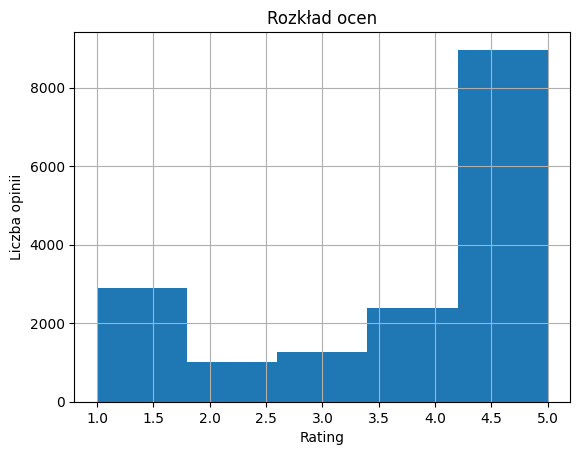

In [10]:

df[BRAND_COL].fillna("Unknown", inplace=True)
df[RATING_COL].hist(bins=5)
plt.xlabel("Rating"); plt.ylabel("Liczba opinii"); plt.title("Rozkład ocen")
plt.show()

df["sentiment"] = (df[RATING_COL] >= 3).astype(int)

import importlib, subprocess, sys
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "spacy"])
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm", "-q"])
    importlib.reload(spacy)
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text(text):
    doc = nlp(str(text).lower())
    tokens = [t.lemma_ for t in doc if t.is_alpha and not t.is_stop]
    return " ".join(tokens)

df["clean_text"] = df[TEXT_COL].fillna("").apply(clean_text)


# Text preprocessing
1. Change the words into its root words using spacy
2. Remove stopwords (optional)

# Tokenizing



Use Tokenizer to tokenize text

Replace value of oov_token is set to be ‘OOV’. That means any unknown words will be replaced by oov_token.

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_WORDS = 20_000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="OOV")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])


# Padding

Pad sequences to maximal length



In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = max(len(s) for s in sequences)  # możesz też ustawić stałą, np. 100
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")
y = df["sentiment"].values


# Model Creation


Model:

*   Embedding
*   LSTM (30 units)
*   Dense (2 layers, 2 x relu, last layer-  sigmoid)

Loss function: binary cross entropy , optimizer = 'adam'



Try to  build network like this:

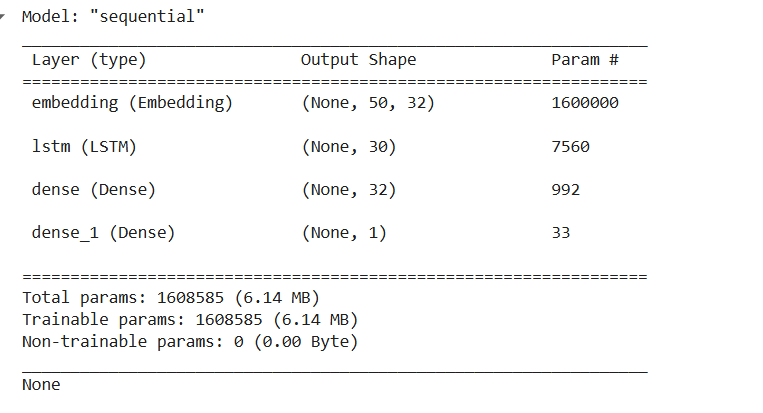

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

EMB_DIM = 128

model = Sequential([
    Input(shape=(MAX_LEN,)),                 # ⬅️ określa wymiar sekwencji
    Embedding(input_dim=MAX_WORDS, output_dim=EMB_DIM),
    LSTM(30),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1,  activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1052, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │        19,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,583,177 (9.85 MB)

 Trainable params: 2,583,177 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

# Split Data into Train and Test

Test: 30% of randomly chosen  observations.
Random Seed: 10

In [18]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
    X,
    y,
    df[TEXT_COL].values,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)


# Model Training

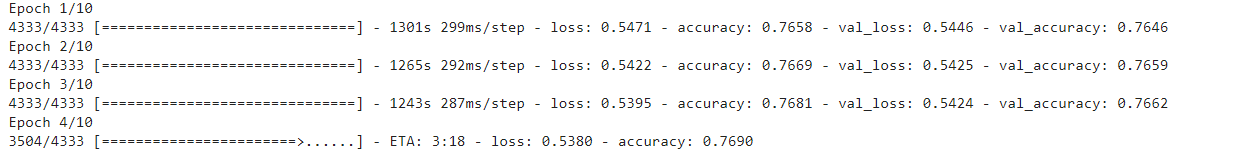

# Performance Metrics and Accuracy

Perform binary prediction on test data set

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score


y_pred = (model.predict(X_test).ravel() >= 0.5).astype(int)
print("LSTM accuracy:", accuracy_score(y_test, y_pred))
print("LSTM confusion matrix:\n", confusion_matrix(y_test, y_pred))


156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step
LSTM accuracy: 0.23656130461042882
LSTM confusion matrix:
 [[1175    0]
 [3792    0]]


In [20]:
import nltk, numpy as np
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

sid = SentimentIntensityAnalyzer()

def vader_label(text):
    return 1 if sid.polarity_scores(str(text))["compound"] >= 0 else 0

vader_pred = np.array([vader_label(t) for t in text_test])

print("VADER accuracy:", accuracy_score(y_test, vader_pred))
print("VADER confusion matrix:\n", confusion_matrix(y_test, vader_pred))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


VADER accuracy: 0.8276625729816791
VADER confusion matrix:
 [[ 620  555]
 [ 301 3491]]


**Confusion Matrix**

In [22]:
from sklearn.metrics import confusion_matrix
# LSTM Confusion Matrix
print("LSTM confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# VADER Confusion Matrix
print("VADER confusion matrix:")
print(confusion_matrix(y_test, vader_pred))

LSTM confusion matrix:
[[1175    0]
 [3792    0]]
VADER confusion matrix:
[[ 620  555]
 [ 301 3491]]


**Accuracy Score**

In [23]:
from sklearn.metrics import accuracy_score
# LSTM Accuracy
print("LSTM accuracy:", accuracy_score(y_test, y_pred))

# VADER Accuracy
print("VADER accuracy:", accuracy_score(y_test, vader_pred))

LSTM accuracy: 0.23656130461042882
VADER accuracy: 0.8276625729816791
